# MBML project - Milestone 1
This is an overview of the data chosen for the project, the PGM for our data and how we plan on modelling it

### Project Members - 
Siddhi Jain (s212937), Heung Tik Choi (s210239), Daniel Grathwol (s213709)



## Research Question
In the following notebook, we use a data set for traffic accidents from Victoria, Australia over the period 2006 to 2020, focusing specifically on the risk of traffic accidents in specific road segments and areas of Victoria. Traffic accidents are still one of the leading causes of death in the world, so we want to look at where and at what times of day road safety needs to be further improved to reduce the likelihood of accidents. Therefore, we want to predict the probability of accidents in certain areas (postal code, long, lat, road node, streetname - still to be figured out). We want to try different Bayesian Network models and start with a hierarchical multivariate Poisson-lognormal regression.

## Probabilistic Graphical Model

### Data Attributes
- Hour of day - 0-23 
- Day of week - 1-7, 1 is Sunday, 7 is Satuarday
- Month, Year

#### Driver (latent variable):
- Age
- Sex

#### Vehicle (latent variable): 
- Vehicle year - manufacturing year
- Vehicle maker - the brand of the vehicle
- Veh type - the type of vehicle, e.g. truck, sedan etc
- Vehicle move - the movement of vehicle, e.g. u-turn, forward, left turn, righ turn etc

#### Traffic vol - traffic volume (latent variable)
- Road Geometry - e.g. T-intersect, Y-intersect etc.
- Speed zone - the speed limit
- Postcode - the postcode when the accident happened

#### Ex env - external environment (latent variable)
- Atmosph cond - the atmospheric condition when the accident happened, e.g cloudy, clear, raining
- Road surface type - if it is paved, unpaved, gravel
- Surface condition - road surface condition, e.g. dry, wet, icy etc 


The variables are subject to change we are considering to use variables like road segment and street name for more accurate predictions

In [1]:
from IPython import display
display.Image("pgm.png")


FileNotFoundError: No such file or directory: 'pgm.png'

FileNotFoundError: No such file or directory: 'pgm.png'

<IPython.core.display.Image object>

## Importing libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar


## Importing data

In [3]:
#import the data from crash stats source: https://discover.data.vic.gov.au/dataset/crash-stats-data-extract

df_accident = pd.read_csv("data/ACCIDENT.csv")
df_accident_location = pd.read_csv("data/ACCIDENT_LOCATION.csv")
df_accident_event = pd.read_csv("data/ACCIDENT_EVENT.csv")
df_accident_chainage = pd.read_csv("data/ACCIDENT_CHAINAGE.csv")
df_atmospheric_cond = pd.read_csv("data/ATMOSPHERIC_COND.csv")
df_subdca = pd.read_csv("data/SUBDCA.csv")
df_person = pd.read_csv("data/PERSON.csv")
df_road_surface_condition = pd.read_csv("data/ROAD_SURFACE_COND.csv")
df_vehicle = pd.read_csv("data/VEHICLE.csv")
df_node = pd.read_csv("data/NODE.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,9,10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,25,26,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data preparation
We would first select the data that we think is relevant to the topic and transform it

In [4]:
# we picked the parameters we think could be used for bayesian inference

df_accident_var = df_accident[["ACCIDENT_NO", "ACCIDENTDATE", "ACCIDENTTIME", "ACCIDENT_TYPE", "DAY_OF_WEEK", "NO_OF_VEHICLES", "NO_PERSONS", "NO_PERSONS_INJ_2", "NO_PERSONS_INJ_3", "NO_PERSONS_KILLED", "ROAD_GEOMETRY", "SPEED_ZONE"]]
df_accident_location_var = df_accident_location[["ACCIDENT_NO", "DIRECTION_LOCATION"]]
df_atmospheric_cond_var = df_atmospheric_cond[["ACCIDENT_NO", "ATMOSPH_COND"]]
df_person_var = df_person[["ACCIDENT_NO", "AGE", "SEX", "ROAD_USER_TYPE", "POSTCODE"]]
df_road_surface_condition_var = df_road_surface_condition[["ACCIDENT_NO", "SURFACE_COND"]]
df_vehicle_var = df_vehicle[["ACCIDENT_NO", "VEHICLE_YEAR_MANUF", "ROAD_SURFACE_TYPE", "VEHICLE_TYPE", "VEHICLE_MAKE", "VEHICLE_MOVEMENT"]]

In [5]:
# merging those parameters and drop the na values

df_accident_all = pd.merge(df_accident_var, df_accident_location_var, on = "ACCIDENT_NO")
df_accident_all = pd.merge(df_accident_all, df_person_var, on = "ACCIDENT_NO")
df_accident_all = pd.merge(df_accident_all, df_road_surface_condition_var, on = "ACCIDENT_NO")
df_accident_all = pd.merge(df_accident_all, df_vehicle_var, on = "ACCIDENT_NO")
df_accident_all = pd.merge(df_accident_all, df_atmospheric_cond_var, on = "ACCIDENT_NO")
df_accident_all['VEHICLE_MOVEMENT'].replace('  ', np.nan, inplace=True)
df_accident_all = df_accident_all.dropna()

## Data Transformation

In [6]:
# converting direction to numerical data

from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()

direction_labels = gle.fit_transform(df_accident_all['DIRECTION_LOCATION'])
direction_mappings = {index: label for index, label in enumerate(gle.classes_)}
df_accident_all['DIRECTION_LOCATION'] = direction_labels


In [7]:
# converting sex to numerical data

gle = LabelEncoder()

sex_labels = gle.fit_transform(df_accident_all['SEX'])
sex_mappings = {index: label for index, label in enumerate(gle.classes_)}
df_accident_all['SEX'] = sex_labels

In [8]:
# converting road_user_type to numerical data

df_accident_all['ROAD_USER_TYPE'] = df_accident_all['ROAD_USER_TYPE'].astype('int')

gle = LabelEncoder()

rut_labels = gle.fit_transform(df_accident_all['ROAD_USER_TYPE'])
rut_mappings = {index: label for index, label in enumerate(gle.classes_)}
df_accident_all['ROAD_USER_TYPE'] = rut_labels

In [9]:
# converting vehicle_make to numerical data

gle = LabelEncoder()

vm_labels = gle.fit_transform(df_accident_all['VEHICLE_MAKE'])
vm_mappings = {index: label for index, label in enumerate(gle.classes_)}
df_accident_all['VEHICLE_MAKE'] = vm_labels

In [10]:
# converting vehicle_movement to numerical data

df_accident_all['VEHICLE_MOVEMENT'] = df_accident_all['VEHICLE_MOVEMENT'].astype('int')

gle = LabelEncoder()

mv_labels = gle.fit_transform(df_accident_all['VEHICLE_MOVEMENT'])
mv_mappings = {index: label for index, label in enumerate(gle.classes_)}
df_accident_all['VEHICLE_MOVEMENT'] = mv_labels

In [11]:
# we only need the driver information for the accident, 2-driver, 4-motorcyclist, 6-bicyclist, 7-other driver
is_driver = [2, 4, 6, 7]
df_accident_all.ROAD_USER_TYPE.isin(is_driver)
df_accident_all_is_driver = df_accident_all[df_accident_all.ROAD_USER_TYPE.isin(is_driver)]

In [12]:
# transform the "ACCIDENTTIME" to datetime format
df_accident_all_is_driver["ACCIDENTDATE"] = pd.to_datetime(df_accident_all_is_driver["ACCIDENTDATE"])
df_accident_all_is_driver["ACCIDENTTIME"] = pd.to_datetime(df_accident_all_is_driver["ACCIDENTTIME"])
df_accident_all_is_driver["ACCIDENTTIME"] = df_accident_all_is_driver["ACCIDENTTIME"].dt.hour
df_accident_all_is_driver["ACCIDENTMONTH"] = df_accident_all_is_driver["ACCIDENTDATE"].dt.month
df_accident_all_is_driver["ACCIDENTYEAR"] = df_accident_all_is_driver["ACCIDENTDATE"].dt.year

<ipython-input-12-0e97ca46d1ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accident_all_is_driver["ACCIDENTDATE"] = pd.to_datetime(df_accident_all_is_driver["ACCIDENTDATE"])
<ipython-input-12-0e97ca46d1ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accident_all_is_driver["ACCIDENTTIME"] = pd.to_datetime(df_accident_all_is_driver["ACCIDENTTIME"])
<ipython-input-12-0e97ca46d1ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [13]:
df_accident_all_is_driver.to_csv("accident_only_driver.csv", index=False)

## Summary plots
Here are some basic summary plots to better understand the information in the dataset

In [14]:
df_accident_all_is_driver.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,DAY_OF_WEEK,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,...,POSTCODE,SURFACE_COND,VEHICLE_YEAR_MANUF,ROAD_SURFACE_TYPE,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MOVEMENT,ATMOSPH_COND,ACCIDENTMONTH,ACCIDENTYEAR
3,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,1996.0,1,1,369,0,1,1,2006
4,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2003.0,1,1,534,1,1,1,2006
5,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2001.0,1,3,181,1,1,1,2006
6,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,1996.0,1,1,369,0,1,1,2006
7,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2003.0,1,1,534,1,1,1,2006


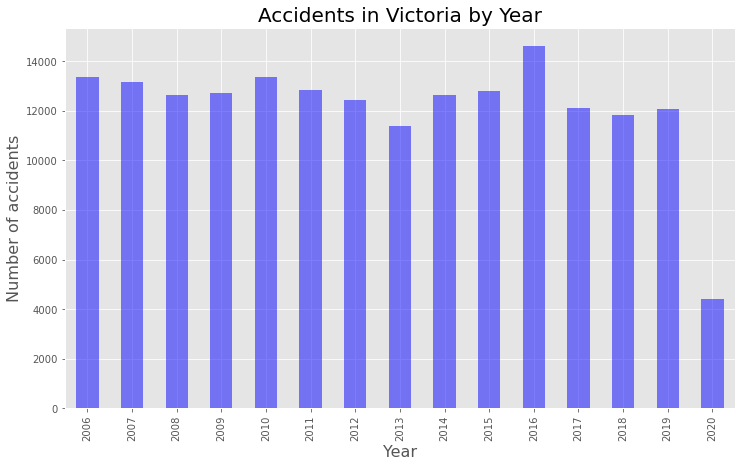

In [15]:
# Accidents by year

plt.style.use('ggplot')

accidents_year = df_accident_all_is_driver.groupby(df_accident_all_is_driver['ACCIDENTDATE'].dt.year).count().ACCIDENTDATE



# plot accidents per day
accidents_year.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Victoria by Year', fontsize=20)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16);

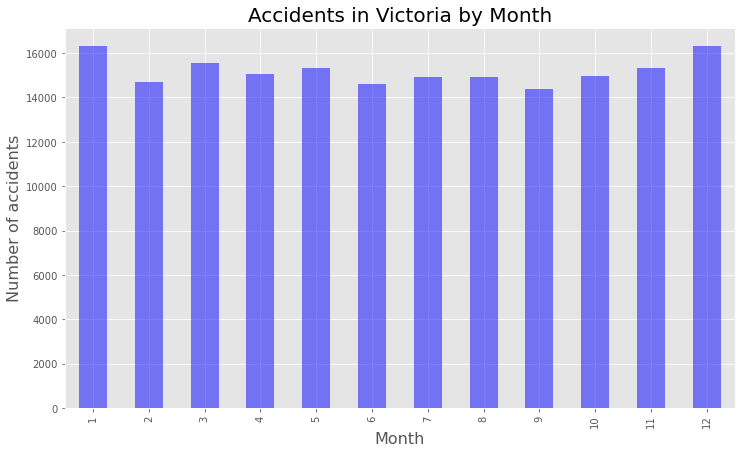

In [16]:
# Accidents by months

accidents_month = df_accident_all_is_driver.groupby(df_accident_all_is_driver['ACCIDENTDATE'].dt.month).count().ACCIDENTDATE


# plot accidents per month
accidents_month.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Victoria by Month', fontsize=20)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16);

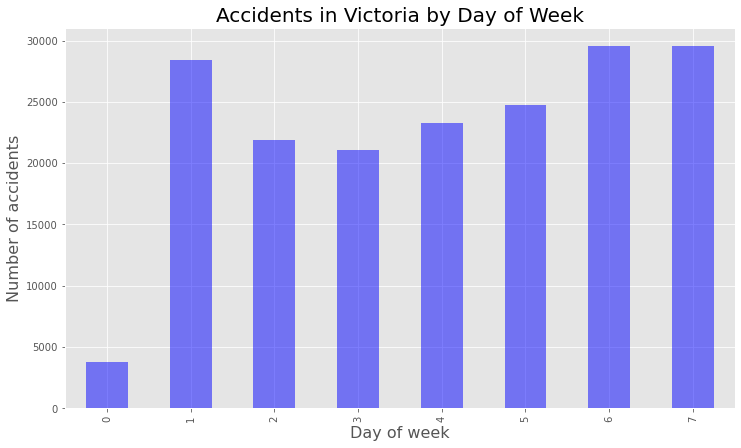

In [17]:
# Accidents by day of week (1=Sunday, 2=Monday, 3=Tuesday, 4=Wednesday, 5=Thursday, 6=Friday, 7=Saturday)

plt.style.use('ggplot')

accidents_day = df_accident_all_is_driver.groupby(df_accident_all_is_driver['DAY_OF_WEEK']).count().ACCIDENTDATE



# plot accidents per day
accidents_day.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Victoria by Day of Week', fontsize=20)
plt.xlabel('Day of week',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16);

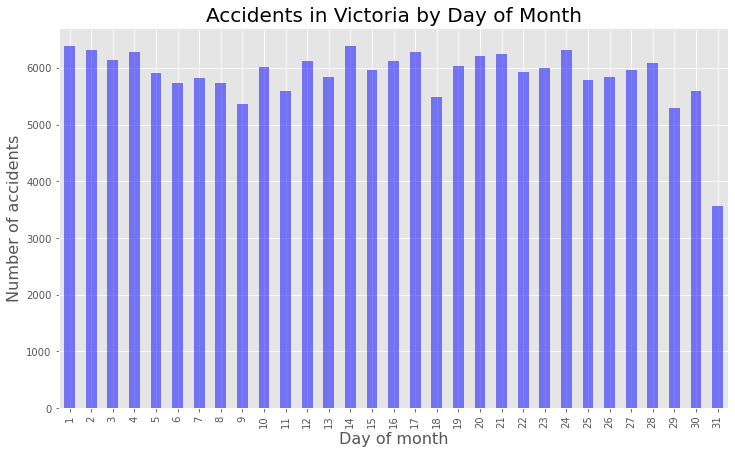

In [18]:
# Accidents by day of month

plt.style.use('ggplot')

accidents_day = df_accident_all_is_driver.groupby(df_accident_all_is_driver['ACCIDENTDATE'].dt.day).count().ACCIDENTDATE



# plot accidents per day
accidents_day.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Victoria by Day of Month', fontsize=20)
plt.xlabel('Day of month',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16);

<AxesSubplot:>

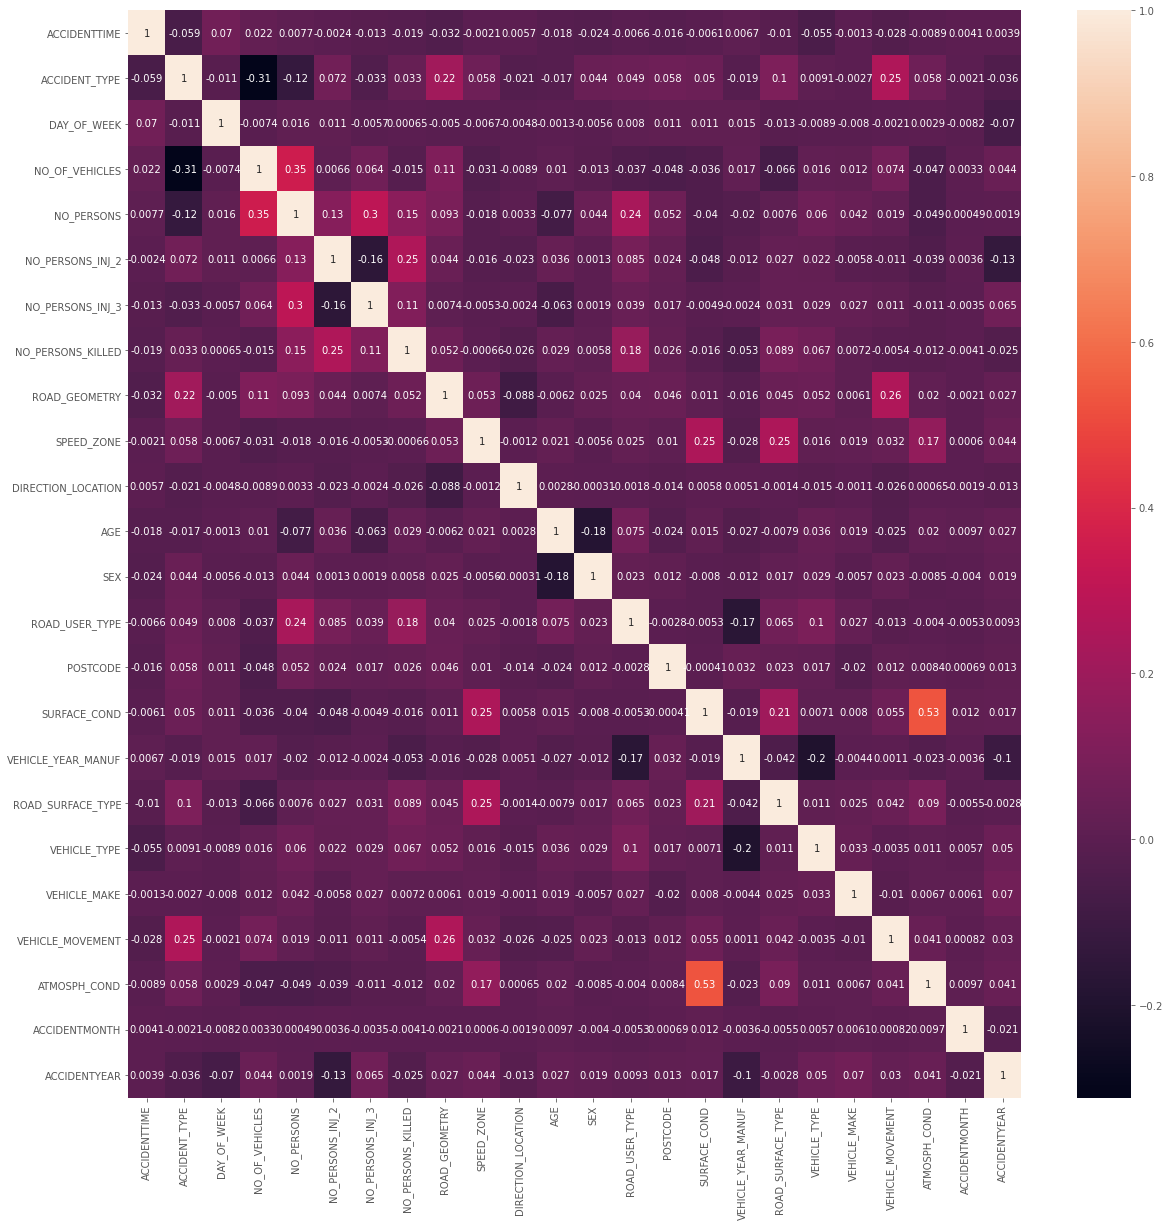

In [19]:
# heatmap of correlation between all the variables

figure = plt.subplots(figsize=(20,20))
sns.heatmap(df_accident_all_is_driver.corr(), annot=True)

In [20]:
df_accident_all_is_driver.head()


,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,DAY_OF_WEEK,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,...,POSTCODE,SURFACE_COND,VEHICLE_YEAR_MANUF,ROAD_SURFACE_TYPE,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MOVEMENT,ATMOSPH_COND,ACCIDENTMONTH,ACCIDENTYEAR
3,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,1996.0,1,1,369,0,1,1,2006
4,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2003.0,1,1,534,1,1,1,2006
5,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2001.0,1,3,181,1,1,1,2006
6,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,1996.0,1,1,369,0,1,1,2006
7,T20060000010,2006-01-13,12,1,6,3,6,0,1,0,...,7310.0,1,2003.0,1,1,534,1,1,1,2006


In [21]:
df_accident_all = df_accident_all_is_driver
df_accident_all_is_driver = df_accident_all_is_driver.drop(columns=['ACCIDENT_NO', 'ACCIDENTDATE'])
df_accident_all_is_driver = df_accident_all_is_driver.astype(str).apply(lambda x: x.name + "_" + x)
df_accident_all_is_driver

,ACCIDENTTIME,ACCIDENT_TYPE,DAY_OF_WEEK,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,ROAD_GEOMETRY,SPEED_ZONE,...,POSTCODE,SURFACE_COND,VEHICLE_YEAR_MANUF,ROAD_SURFACE_TYPE,VEHICLE_TYPE,VEHICLE_MAKE,VEHICLE_MOVEMENT,ATMOSPH_COND,ACCIDENTMONTH,ACCIDENTYEAR
3,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_6,NO_OF_VEHICLES_3,NO_PERSONS_6,NO_PERSONS_INJ_2_0,NO_PERSONS_INJ_3_1,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_1,SPEED_ZONE_60,...,POSTCODE_7310.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_1996.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_369,VEHICLE_MOVEMENT_0,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2006
4,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_6,NO_OF_VEHICLES_3,NO_PERSONS_6,NO_PERSONS_INJ_2_0,NO_PERSONS_INJ_3_1,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_1,SPEED_ZONE_60,...,POSTCODE_7310.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2003.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_534,VEHICLE_MOVEMENT_1,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2006
5,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_6,NO_OF_VEHICLES_3,NO_PERSONS_6,NO_PERSONS_INJ_2_0,NO_PERSONS_INJ_3_1,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_1,SPEED_ZONE_60,...,POSTCODE_7310.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2001.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_3,VEHICLE_MAKE_181,VEHICLE_MOVEMENT_1,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2006
6,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_6,NO_OF_VEHICLES_3,NO_PERSONS_6,NO_PERSONS_INJ_2_0,NO_PERSONS_INJ_3_1,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_1,SPEED_ZONE_60,...,POSTCODE_7310.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_1996.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_369,VEHICLE_MOVEMENT_0,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2006
7,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_6,NO_OF_VEHICLES_3,NO_PERSONS_6,NO_PERSONS_INJ_2_0,NO_PERSONS_INJ_3_1,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_1,SPEED_ZONE_60,...,POSTCODE_7310.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2003.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_534,VEHICLE_MOVEMENT_1,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020143,ACCIDENTTIME_17,ACCIDENT_TYPE_1,DAY_OF_WEEK_4,NO_OF_VEHICLES_2,NO_PERSONS_6,NO_PERSONS_INJ_2_1,NO_PERSONS_INJ_3_0,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_5,SPEED_ZONE_80,...,POSTCODE_3975.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2006.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_229,VEHICLE_MOVEMENT_1,ATMOSPH_COND_1,ACCIDENTMONTH_10,ACCIDENTYEAR_2020
1020144,ACCIDENTTIME_17,ACCIDENT_TYPE_1,DAY_OF_WEEK_4,NO_OF_VEHICLES_2,NO_PERSONS_6,NO_PERSONS_INJ_2_1,NO_PERSONS_INJ_3_0,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_5,SPEED_ZONE_80,...,POSTCODE_3975.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2017.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_1,VEHICLE_MAKE_244,VEHICLE_MOVEMENT_0,ATMOSPH_COND_1,ACCIDENTMONTH_10,ACCIDENTYEAR_2020
1020172,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_0,NO_OF_VEHICLES_2,NO_PERSONS_4,NO_PERSONS_INJ_2_1,NO_PERSONS_INJ_3_0,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_5,SPEED_ZONE_50,...,POSTCODE_3133.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_2019.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_2,VEHICLE_MAKE_47,VEHICLE_MOVEMENT_9,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2020
1020173,ACCIDENTTIME_12,ACCIDENT_TYPE_1,DAY_OF_WEEK_0,NO_OF_VEHICLES_2,NO_PERSONS_4,NO_PERSONS_INJ_2_1,NO_PERSONS_INJ_3_0,NO_PERSONS_KILLED_0,ROAD_GEOMETRY_5,SPEED_ZONE_50,...,POSTCODE_3133.0,SURFACE_COND_1,VEHICLE_YEAR_MANUF_0.0,ROAD_SURFACE_TYPE_1,VEHICLE_TYPE_13,VEHICLE_MAKE_0,VEHICLE_MOVEMENT_0,ATMOSPH_COND_1,ACCIDENTMONTH_1,ACCIDENTYEAR_2020


In [22]:
df_accident_all_is_driver.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182375 entries, 3 to 1020180
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   ACCIDENTTIME        182375 non-null  object
 1   ACCIDENT_TYPE       182375 non-null  object
 2   DAY_OF_WEEK         182375 non-null  object
 3   NO_OF_VEHICLES      182375 non-null  object
 4   NO_PERSONS          182375 non-null  object
 5   NO_PERSONS_INJ_2    182375 non-null  object
 6   NO_PERSONS_INJ_3    182375 non-null  object
 7   NO_PERSONS_KILLED   182375 non-null  object
 8   ROAD_GEOMETRY       182375 non-null  object
 9   SPEED_ZONE          182375 non-null  object
 10  DIRECTION_LOCATION  182375 non-null  object
 11  AGE                 182375 non-null  object
 12  SEX                 182375 non-null  object
 13  ROAD_USER_TYPE      182375 non-null  object
 14  POSTCODE            182375 non-null  object
 15  SURFACE_COND        182375 non-null  object
 16  V

In [23]:
word_dictionary = []
for col in df_accident_all_is_driver:
    word_dictionary.extend(df_accident_all_is_driver[col].unique())

word_dictionary

['ACCIDENTTIME_12',
 'ACCIDENTTIME_19',
 'ACCIDENTTIME_10',
 'ACCIDENTTIME_8',
 'ACCIDENTTIME_11',
 'ACCIDENTTIME_16',
 'ACCIDENTTIME_18',
 'ACCIDENTTIME_13',
 'ACCIDENTTIME_17',
 'ACCIDENTTIME_3',
 'ACCIDENTTIME_6',
 'ACCIDENTTIME_14',
 'ACCIDENTTIME_23',
 'ACCIDENTTIME_7',
 'ACCIDENTTIME_15',
 'ACCIDENTTIME_21',
 'ACCIDENTTIME_22',
 'ACCIDENTTIME_9',
 'ACCIDENTTIME_2',
 'ACCIDENTTIME_20',
 'ACCIDENTTIME_0',
 'ACCIDENTTIME_5',
 'ACCIDENTTIME_1',
 'ACCIDENTTIME_4',
 'ACCIDENT_TYPE_1',
 'ACCIDENT_TYPE_7',
 'ACCIDENT_TYPE_4',
 'ACCIDENT_TYPE_6',
 'ACCIDENT_TYPE_2',
 'ACCIDENT_TYPE_3',
 'ACCIDENT_TYPE_5',
 'ACCIDENT_TYPE_8',
 'ACCIDENT_TYPE_9',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_0',
 'NO_OF_VEHICLES_3',
 'NO_OF_VEHICLES_2',
 'NO_OF_VEHICLES_1',
 'NO_OF_VEHICLES_4',
 'NO_OF_VEHICLES_5',
 'NO_OF_VEHICLES_6',
 'NO_OF_VEHICLES_10',
 'NO_OF_VEHICLES_7',
 'NO_OF_VEHICLES_8',
 'NO_OF_VEHICLES

In [24]:
# Create Docs
df_docs = df_accident_all_is_driver.values.tolist()
df_docs

[['ACCIDENTTIME_12',
  'ACCIDENT_TYPE_1',
  'DAY_OF_WEEK_6',
  'NO_OF_VEHICLES_3',
  'NO_PERSONS_6',
  'NO_PERSONS_INJ_2_0',
  'NO_PERSONS_INJ_3_1',
  'NO_PERSONS_KILLED_0',
  'ROAD_GEOMETRY_1',
  'SPEED_ZONE_60',
  'DIRECTION_LOCATION_8',
  'AGE_43.0',
  'SEX_1',
  'ROAD_USER_TYPE_2',
  'POSTCODE_7310.0',
  'SURFACE_COND_1',
  'VEHICLE_YEAR_MANUF_1996.0',
  'ROAD_SURFACE_TYPE_1',
  'VEHICLE_TYPE_1',
  'VEHICLE_MAKE_369',
  'VEHICLE_MOVEMENT_0',
  'ATMOSPH_COND_1',
  'ACCIDENTMONTH_1',
  'ACCIDENTYEAR_2006'],
 ['ACCIDENTTIME_12',
  'ACCIDENT_TYPE_1',
  'DAY_OF_WEEK_6',
  'NO_OF_VEHICLES_3',
  'NO_PERSONS_6',
  'NO_PERSONS_INJ_2_0',
  'NO_PERSONS_INJ_3_1',
  'NO_PERSONS_KILLED_0',
  'ROAD_GEOMETRY_1',
  'SPEED_ZONE_60',
  'DIRECTION_LOCATION_8',
  'AGE_43.0',
  'SEX_1',
  'ROAD_USER_TYPE_2',
  'POSTCODE_7310.0',
  'SURFACE_COND_1',
  'VEHICLE_YEAR_MANUF_2003.0',
  'ROAD_SURFACE_TYPE_1',
  'VEHICLE_TYPE_1',
  'VEHICLE_MAKE_534',
  'VEHICLE_MOVEMENT_1',
  'ATMOSPH_COND_1',
  'ACCIDENTMONT

In [25]:
!pip install gensim==4.2.0


     |████████████████████████████████| 24.0 MB 973 kB/s eta 0:00:01�██████████▏| 23.5 MB 1.0 MB/s eta 0:00:01�██████████▊| 23.8 MB 973 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.9 MB/s eta 0:00:01


In [51]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 48 kB/s eta 0:00:011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=f4b3e9d9ce1f145e0c29fe5698337d8fd190b0188f47d74ecc97b68203c4650d
  Stored in directory: /Users/dg/Library/Caches/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=81a715cad0b91218e80fed53670e76d4ffe13fff4807adb556926bdf019baa49
  Stored in directory: /Users/dg/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built pyLDAvis sklearn


In [30]:
# importing libraries
import gensim
from gensim import corpora, models
from gensim.test.utils import datapath


# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(df_docs)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in df_docs]

# create LDA model using preferred hyperparameters
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                         num_topics=3, 
                                         id2word=dictionary, 
                                         passes=4, 
                                         workers=2,
                                         random_state=21)

# Save LDA model to disk (local)
path_to_model = "/Users/dg/Documents/Development/model-based-ml/Project/model/model"

# Save LDA model to disk (deepnote)
#path_to_model = datapath("model")


lda_model.save(path_to_model)

IsADirectoryError: [Errno 21] Is a directory: '/Users/dg/Documents/Development/model-based-ml/Project'

In [57]:
# for each topic, print words occuring in that topic
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.042*"NO_PERSONS_3" + 0.039*"NO_PERSONS_INJ_3_1" + 0.038*"SPEED_ZONE_60" + 0.033*"ROAD_GEOMETRY_1" + 0.027*"SEX_1" + 0.025*"ROAD_GEOMETRY_2" + 0.022*"NO_PERSONS_4" + 0.020*"DIRECTION_LOCATION_9" + 0.019*"VEHICLE_MOVEMENT_1" + 0.019*"SPEED_ZONE_50"
Topic: 1 
Words: 0.034*"ROAD_GEOMETRY_5" + 0.029*"NO_OF_VEHICLES_3" + 0.028*"SPEED_ZONE_80" + 0.027*"NO_PERSONS_INJ_3_1" + 0.026*"VEHICLE_TYPE_2" + 0.024*"SEX_1" + 0.020*"SPEED_ZONE_60" + 0.017*"NO_PERSONS_INJ_3_2" + 0.017*"ACCIDENTYEAR_2019" + 0.016*"NO_PERSONS_5"
Topic: 2 
Words: 0.071*"ROAD_GEOMETRY_5" + 0.048*"SPEED_ZONE_100" + 0.032*"SEX_1" + 0.028*"NO_PERSONS_INJ_3_0" + 0.028*"NO_OF_VEHICLES_1" + 0.027*"VEHICLE_MOVEMENT_17" + 0.021*"NO_PERSONS_INJ_2_1" + 0.020*"ACCIDENT_TYPE_4" + 0.017*"SURFACE_COND_2" + 0.016*"NO_PERSONS_2"


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
import pyLDAvis.gensim_models as gensimvis

prepared = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(prepared)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c302eb41-8fd3-40b0-a2f8-14b0852194c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>